# Challenge N°2 - Tipos de regresión


El presente notebook está basado en el estudio de Debernardi et al (2020) [[1](https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1003489)], quienes propusieron los siguientes biomarcadores para el diagnóstico de adenocarcinoma ductal pancreático (un tipo de cáncer de páncreas):

* **Creatinina**, la cuál es indicadora de la función del riñón
* **YVLE1**, relacionada a la metástasis del tumor
* **REG1B**, asociada a la regeneración del páncreas
* **TFF1**, asociada a la regeneración del tracto urinario

La base de datos (raw data) puede encontrarse en el artículo original [[1](https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1003489)](ver Material Suplementario). Por conveniencia, estamos usando los archivos .csv del challenge de Kaggle titulado *Urinary biomarkers for pancreatic cancer* [[2](https://www.kaggle.com/datasets/johnjdavisiv/urinary-biomarkers-for-pancreatic-cancer)]

## Análisis exploratorio de datos

Importamos las librerías que utilizaremos para el análisis y visualización de datos

In [347]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [319]:
db = pd.read_csv('Debernardi_2020.csv')
db.head()

,sample_id,patient_cohort,sample_origin,age,sex,diagnosis,stage,benign_sample_diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,S1,Cohort1,BPTB,33,F,1,NaN,NaN,11.7,1.83222,0.893219,52.94884,654.282174,1262.000
1,S10,Cohort1,BPTB,81,F,1,NaN,NaN,NaN,0.97266,2.037585,94.46703,209.488250,228.407
2,S100,Cohort2,BPTB,51,M,1,NaN,NaN,7.0,0.78039,0.145589,102.36600,461.141000,NaN
3,S101,Cohort2,BPTB,61,M,1,NaN,NaN,8.0,0.70122,0.002805,60.57900,142.950000,NaN
4,S102,Cohort2,BPTB,62,M,1,NaN,NaN,9.0,0.21489,0.000860,65.54000,41.088000,NaN


En base al artículo, la siguiente tabla describe los datos.

| Categoría | Descripción |
|---|---|
| sample_id | Identificador de cada paciente |
| patient_cohort | Cohorte 1: muestras antiguas del Banco de Tejidos, Cohorte 2: muestras agregadas en el estudio |
| sample_origin | Banco de Tejidos del cuál provienen las muestras |
| age | Edad [años] |
| sex | Sexo [M = masculino, F = femenino] |
| diagnosis | 1 = control negativo, 2 = enfermedad benigna, 3 = adenocarcinoma |
| stage | Estadio del cáncer (IA, IB, IIA, IIB, III, IV) [solo en pacientes con cáncer] |
| benign_sample_diagnosis | Diagnóticoc [para pacientes sin cáncer] |
| plasma_CA19_9 | [CA19-9] en sangre |
| creatinine | marcador propuesto de cáncer N°1 |
| LYVE1 | marcador propuesto de cáncer N°2 |
| REG1B | marcador propuesto de cáncer N°3 |
| TFF1 | marcador propuesto de cáncer N°4 |
| REG1A | marcador que se solía utilizar en vez de REG1B |

El objetivo del presente notebook es probar modelos de regresión sobre el dataset elegido. Es decir, evaluar la correlación entre dos variables; en este caso, buscando que dicha correlación permita diferenciar pacientes con adenocarcinoma de pacientes sanos y con tumores benignos. Por lo tanto, no consideramos las siguientes columnas para el análisis: sample_id, patient_cohort (asumimos homogeneidad entre las muestras), sample_origin, stage y benign_sample_diagnosis

In [320]:
db = db.drop(['sample_id', 'patient_cohort', 'sample_origin', 'stage', 'benign_sample_diagnosis'], axis = 1)
db.head()

,age,sex,diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,33,F,1,11.7,1.83222,0.893219,52.94884,654.282174,1262.000
1,81,F,1,NaN,0.97266,2.037585,94.46703,209.488250,228.407
2,51,M,1,7.0,0.78039,0.145589,102.36600,461.141000,NaN
3,61,M,1,8.0,0.70122,0.002805,60.57900,142.950000,NaN
4,62,M,1,9.0,0.21489,0.000860,65.54000,41.088000,NaN


Luego, evaluamos el tipo de datos que tenemos en cada columna

In [321]:
np.shape(db)

(590, 9)

In [322]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            590 non-null    int64  
 1   sex            590 non-null    object 
 2   diagnosis      590 non-null    int64  
 3   plasma_CA19_9  350 non-null    float64
 4   creatinine     590 non-null    float64
 5   LYVE1          590 non-null    float64
 6   REG1B          590 non-null    float64
 7   TFF1           590 non-null    float64
 8   REG1A          306 non-null    float64
dtypes: float64(6), int64(2), object(1)
memory usage: 41.6+ KB


Lo que implica que no existen datos nan. Por otro lado, observamos que los datos de concentración de la proteína Ca19-9 y REG1A solo están presentes en 306 muestras.

In [323]:
print('Número de pacientes sin cáncer con datos de proteína Ca19-9: ' + str(len(db.loc[(db['plasma_CA19_9'] != np.nan) & (db['diagnosis'] == 0)])))

Número de pacientes sin cáncer con datos de proteína Ca19-9: 0


Lo que implica que solo algunos de los pacientes con cáncer fueron testeados para la proteína Ca19-9.

In [324]:
print('Número de pacientes sin cáncer con datos de proteína REG1A: ' + str(len(db.loc[(db['REG1A'] != np.nan) & (db['diagnosis'] == 0)])))

Número de pacientes sin cáncer con datos de proteína REG1A: 0


Del mismo modo para la proteína REG1A. Por lo tanto, ambas serán excluidas del análisis momentáneamente.

In [325]:
db = db.drop(['plasma_CA19_9', 'REG1A'], axis = 1)
db.head()

,age,sex,diagnosis,creatinine,LYVE1,REG1B,TFF1
0,33,F,1,1.83222,0.893219,52.94884,654.282174
1,81,F,1,0.97266,2.037585,94.46703,209.488250
2,51,M,1,0.78039,0.145589,102.36600,461.141000
3,61,M,1,0.70122,0.002805,60.57900,142.950000
4,62,M,1,0.21489,0.000860,65.54000,41.088000


### Conversión a formato adecuado

Las columnas *age* y las referentes a los biomarcadores presentan la clase correcta (*int* y *float*, respectivamente). La base de datos no tiene datos categóricos ni datos faltantes, por lo que no se realizará el análisis respectivo (e.g imputación de variables).

In [326]:
db['sex'].value_counts()

F    299
M    291
Name: sex, dtype: int64

In [327]:
db['age'].value_counts()

68    21
58    20
66    18
67    18
62    17
      ..
86     1
33     1
34     1
89     1
85     1
Name: age, Length: 63, dtype: int64

En el caso de la columna *sex*, se considerará **0** a la clase 'M' y **1** a la clase 'F', mientras que para el diagnóstico, se considerará **0** a las clases 1 y 2, que corresponden a pacientes sanos y pacientes con tumores benignos, respectivamente; y **1** a la clase 2, que corresponde a los pacientes con adenocarcinoma.

In [328]:
"""
También pudo haberse utilizado one hot enconding para la variable sex
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc_df = pd.DataFrame(enc.fit_transform(db[['sex']]).toarray())
db = db.join(enc_df)
db.rename(columns = {0: 'Female', 1: 'Male'}, inplace = True)
db = db.drop(['sex'], axis = 1)

"""

# Reemplazar 'sex' por variable binaria
db['sex'] = db['sex'].replace({'F':1, 'M':0})

# Reemplazar 'diagnóstico' por variable binaria
db['diagnosis'] = db['diagnosis'].replace({1:0, 2:0, 3:1})
db.head()

,age,sex,diagnosis,creatinine,LYVE1,REG1B,TFF1
0,33,1,0,1.83222,0.893219,52.94884,654.282174
1,81,1,0,0.97266,2.037585,94.46703,209.488250
2,51,0,0,0.78039,0.145589,102.36600,461.141000
3,61,0,0,0.70122,0.002805,60.57900,142.950000
4,62,0,0,0.21489,0.000860,65.54000,41.088000


### Visualización de datos

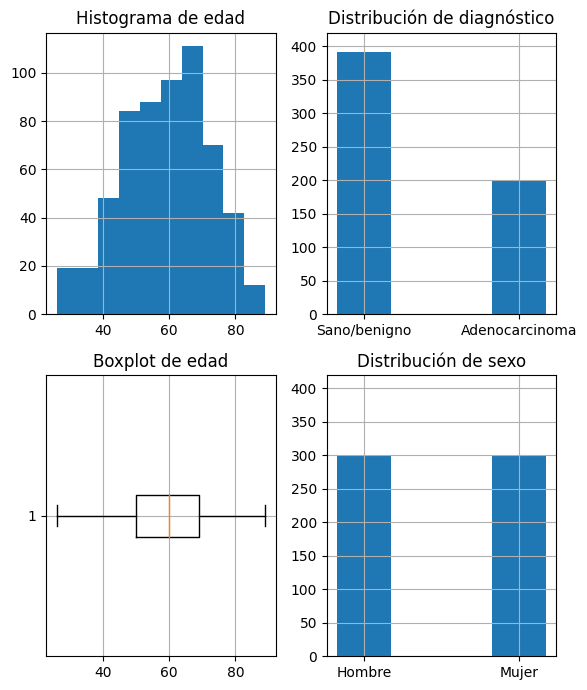

In [331]:
#@title Edad, sexo y distribución de clases
fig, axs = plt.subplots(2,2, figsize = (6,7))

# Histograma y boxplot de edad
axs[0,0].hist(db['age'])
axs[0,0].grid()
axs[0,0].set_title('Histograma de edad')

axs[1,0].boxplot(db['age'], vert = False)
axs[1,0].grid()
axs[1,0].set_title('Boxplot de edad')

# Distribución de clases

axs[0,1].bar(np.arange(2), db['diagnosis'].value_counts(), 0.35)
axs[0,1].grid()
axs[0,1].set_title('Distribución de diagnóstico')
axs[0,1].set_ylim([0, 420])
plt.sca(axs[0, 1])
plt.xticks(range(2), ['Sano/benigno', 'Adenocarcinoma'])

axs[1,1].bar(np.arange(2), db['sex'].value_counts()[1], 0.35)
axs[1,1].grid()
axs[1,1].set_title('Distribución de sexo')
axs[1,1].xaxis.set_major_locator(plt.MaxNLocator(2))
axs[1,1].set_ylim([0, 420])
plt.sca(axs[1, 1])
plt.xticks(range(2), ['Hombre', 'Mujer'])

plt.tight_layout()
plt.show()

La distribución de la columna edad sigue se asemeja mucho (cualitativamente) a la distribución normal. Observamos también que la distribución de sexo se encuentra balanceada. Sin embargo, observamos un desbalance de clases entre la cantidad de datos de pacientes sano y pacientes con adenocarcinoma.

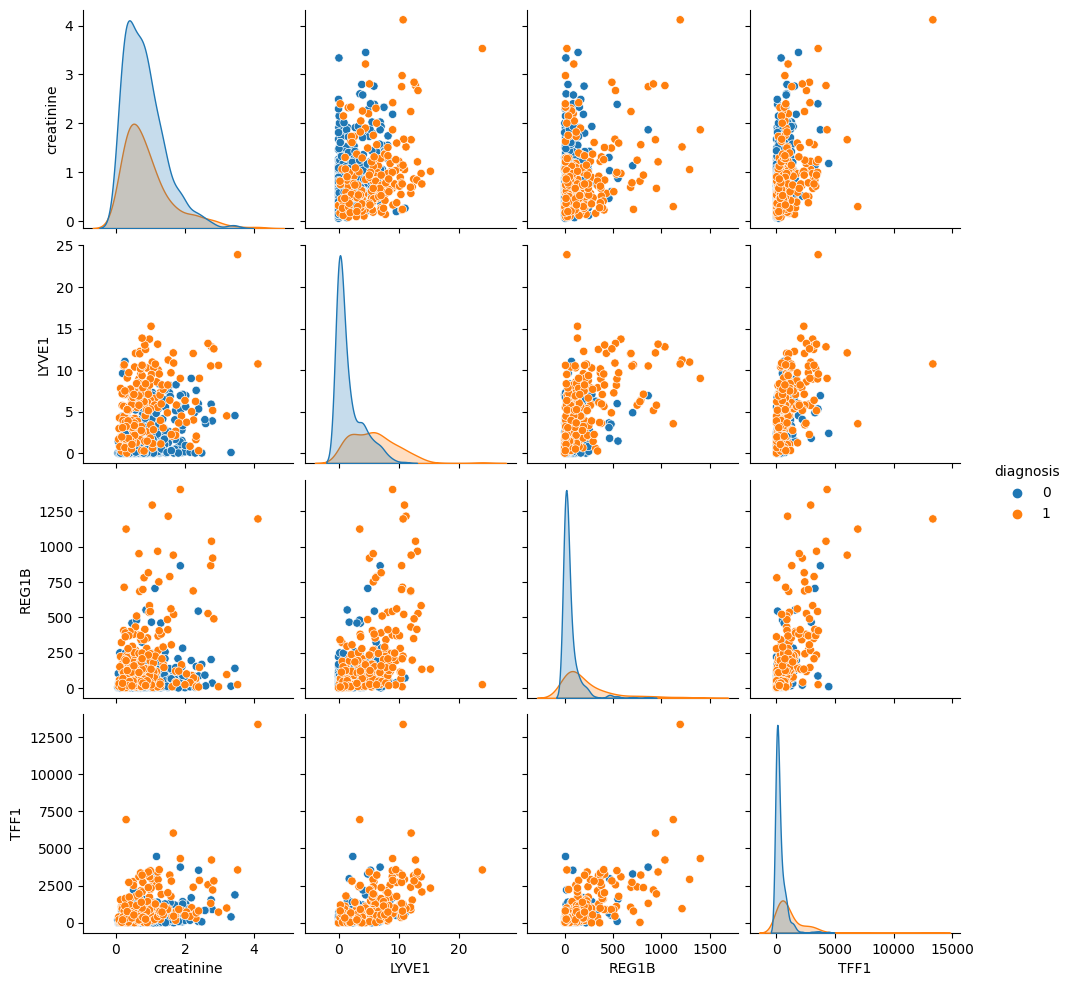

In [332]:
#@title Biomarcadores
biomarkers = db.drop(['age', 'sex'], axis = 1)
sns.pairplot(biomarkers, hue = 'diagnosis')
plt.show()

Por otro lado, con el `pairplot` no es evidente si existe una correlación entre los biomarcadores. Por lo tanto, se separará el dataset en los datos correspondientes a pacientes sanos y a pacientes con adenocarcinoma, y se realizará un `heatmap` con los coeficientes de correlación de Pearson y Spearman.


## Correlación de Pearson y Spearman

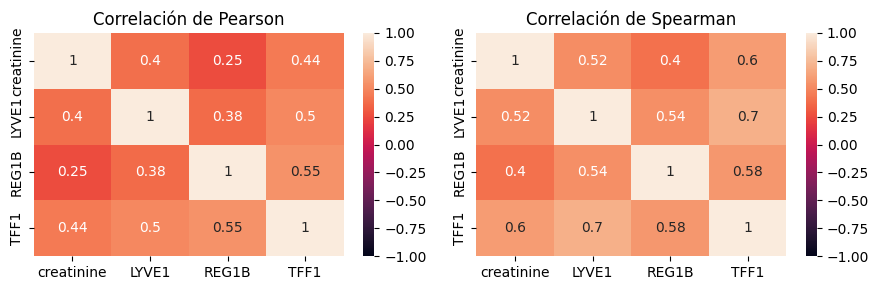

In [334]:
# Separando el dataset por clases
healthy = db[db.diagnosis == 0]
healthy = healthy.drop(['diagnosis'], axis = 1)

# Calculando una matriz de correlaciones para pacientes sanos
corr_pearson = healthy[healthy.keys()[2:6]].corr(method='pearson')
corr_spearman = healthy[healthy.keys()[2:6]].corr(method='spearman')

# Visualizando
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (9,3))
sns.heatmap(corr_pearson, annot=True, vmin=-1, vmax=+1, ax = ax1)
ax1.set_title('Correlación de Pearson')

sns.heatmap(corr_spearman, annot=True, vmin=-1, vmax=+1, ax = ax2)
ax2.set_title('Correlación de Spearman')

plt.tight_layout()
plt.show()

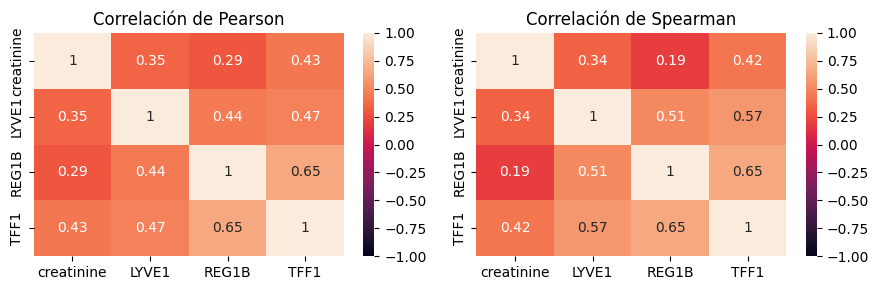

In [335]:
# El mismo código se utilizará para los pacientes con adenocarcinoma
cancer = db[db.diagnosis == 1]
cancer = cancer.drop(['diagnosis'], axis = 1)

# Calculando una matriz de correlaciones para pacientes sanos
corr_pearson = cancer[cancer.keys()[2:6]].corr(method='pearson')
corr_spearman = cancer[cancer.keys()[2:6]].corr(method='spearman')

# Visualizando
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (9,3))
sns.heatmap(corr_pearson, annot=True, vmin=-1, vmax=+1, ax = ax1)
ax1.set_title('Correlación de Pearson')

sns.heatmap(corr_spearman, annot=True, vmin=-1, vmax=+1, ax = ax2)
ax2.set_title('Correlación de Spearman')

plt.tight_layout()
plt.show()

Observamos que no existe un alto grado de correlación entre los biomarcadores. Para seguir explorando el dataset, ampliamos el análisis de correlaciones incluyendo las variables de edad y sexo.

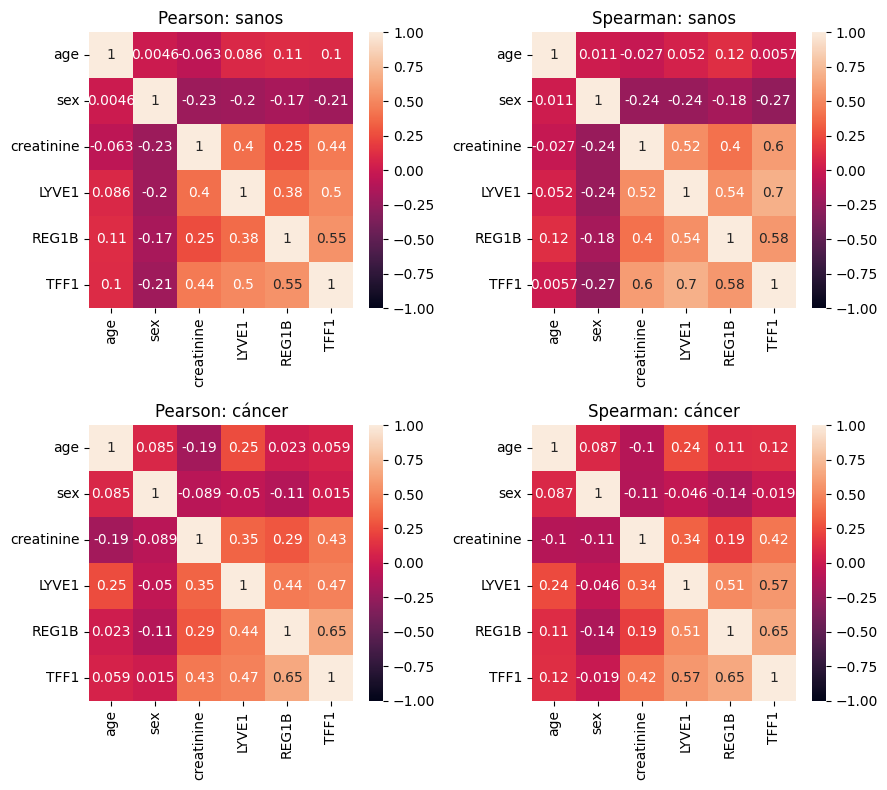

In [340]:
# Calculando la primera matriz de correlaciones
corr_pearson = healthy[healthy.keys()].corr(method='pearson')
corr_spearman = healthy[healthy.keys()].corr(method='spearman')

# Visualizando
fig, axs = plt.subplots(2,2, figsize = (9,8))

sns.heatmap(corr_pearson, annot=True, vmin=-1, vmax=+1, ax = axs[0,0])
axs[0,0].set_title('Pearson: sanos')

sns.heatmap(corr_spearman, annot=True, vmin=-1, vmax=+1, ax = axs[0,1])
axs[0,1].set_title('Spearman: sanos')

corr_pearson = cancer[cancer.keys()].corr(method='pearson')
corr_spearman = cancer[cancer.keys()].corr(method='spearman')

sns.heatmap(corr_pearson, annot=True, vmin=-1, vmax=+1, ax = axs[1,0])
axs[1,0].set_title('Pearson: cáncer')

sns.heatmap(corr_spearman, annot=True, vmin=-1, vmax=+1, ax = axs[1,1])
axs[1,1].set_title('Spearman: cáncer')

plt.tight_layout()
plt.show()

Si bien encontramos diferencias en los coeficientes de Pearson y Spearman entre los pacientes sanos y con adenocarcinoma, nos enfocaremos solo en aquellas características que presentan los mayores valores de coeficiente de Pearson.

## Modelo de regresión lineal

In [341]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

Evaluaremos la relación entre REG1B y TFF1 tanto para pacientes sanos como con adenocarcinoma.

In [359]:
# Para pacientes sanos
X_s = np.array(healthy['REG1B']).reshape(-1,1)
y_s = np.array(healthy['TFF1']).reshape(-1,1)

# Separando el dataset en train y test
X_train, X_test_s, y_train, y_test = train_test_split(X_s,y_s, random_state=47, test_size = 0.3)

# Modelo de regresión lineal
lmodel = LinearRegression()
lmodel.fit(X_train, y_train)

# Métricas de evaluación
y_pred = lmodel.predict(X_test_s)
REG_TFF1_sano_r2 = r2_score(y_test, y_pred)
REG_TFF1_sano_m = lmodel.coef_
REG_TFF1_sano_b = lmodel.intercept_
REG_TFF1_sano = REG_TFF1_sano_m*X_test_s + REG_TFF1_sano_b

In [360]:
# Seguimos la misma lógica para evaluar a los pacientes con adenocarcinoma
X_c = np.array(cancer['REG1B']).reshape(-1,1)
y_c = np.array(cancer['TFF1']).reshape(-1,1)

# Separando el dataset en train y test
X_train, X_test_c, y_train, y_test = train_test_split(X_c,y_c, random_state=47, test_size = 0.3)

# Modelo de regresión lineal
lmodel = LinearRegression()
lmodel.fit(X_train, y_train)

# Métricas de evaluación
y_pred = lmodel.predict(X_test_c)
REG_TFF1_cancer_r2 = r2_score(y_test, y_pred)
REG_TFF1_cancer_m = lmodel.coef_
REG_TFF1_cancer_b = lmodel.intercept_
REG_TFF1_cancer = REG_TFF1_cancer_m*X_test_c + REG_TFF1_cancer_b

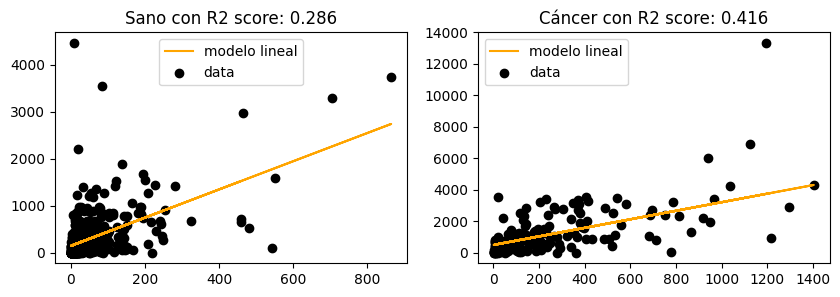

In [362]:
# Visualizando
f, (ax1, ax2) = plt.subplots(1,2, figsize = (10,3))
ax1.plot(X_test_s, REG_TFF1_sano, color = 'orange', label = 'modelo lineal')
ax1.scatter(X_s, y_s, color = 'black', label = 'data')
ax1.legend()
ax1.set_title(f'Sano con R2 score: {REG_TFF1_sano_r2:.3f}')

ax2.plot(X_test_c, REG_TFF1_cancer, color = 'orange', label = 'modelo lineal')
ax2.scatter(X_c, y_c, color = 'black', label = 'data')
ax2.legend()
ax2.set_title(f'Cáncer con R2 score: {REG_TFF1_cancer_r2:.3f}')

plt.show()

Luego, realizamos otro `pairplot` y, en base a los coeficientes de Spearman obtenidos, definir un modelo de regresión polinomial (no lineal), que suponemos que se ajustará mejor a la data mostrada.

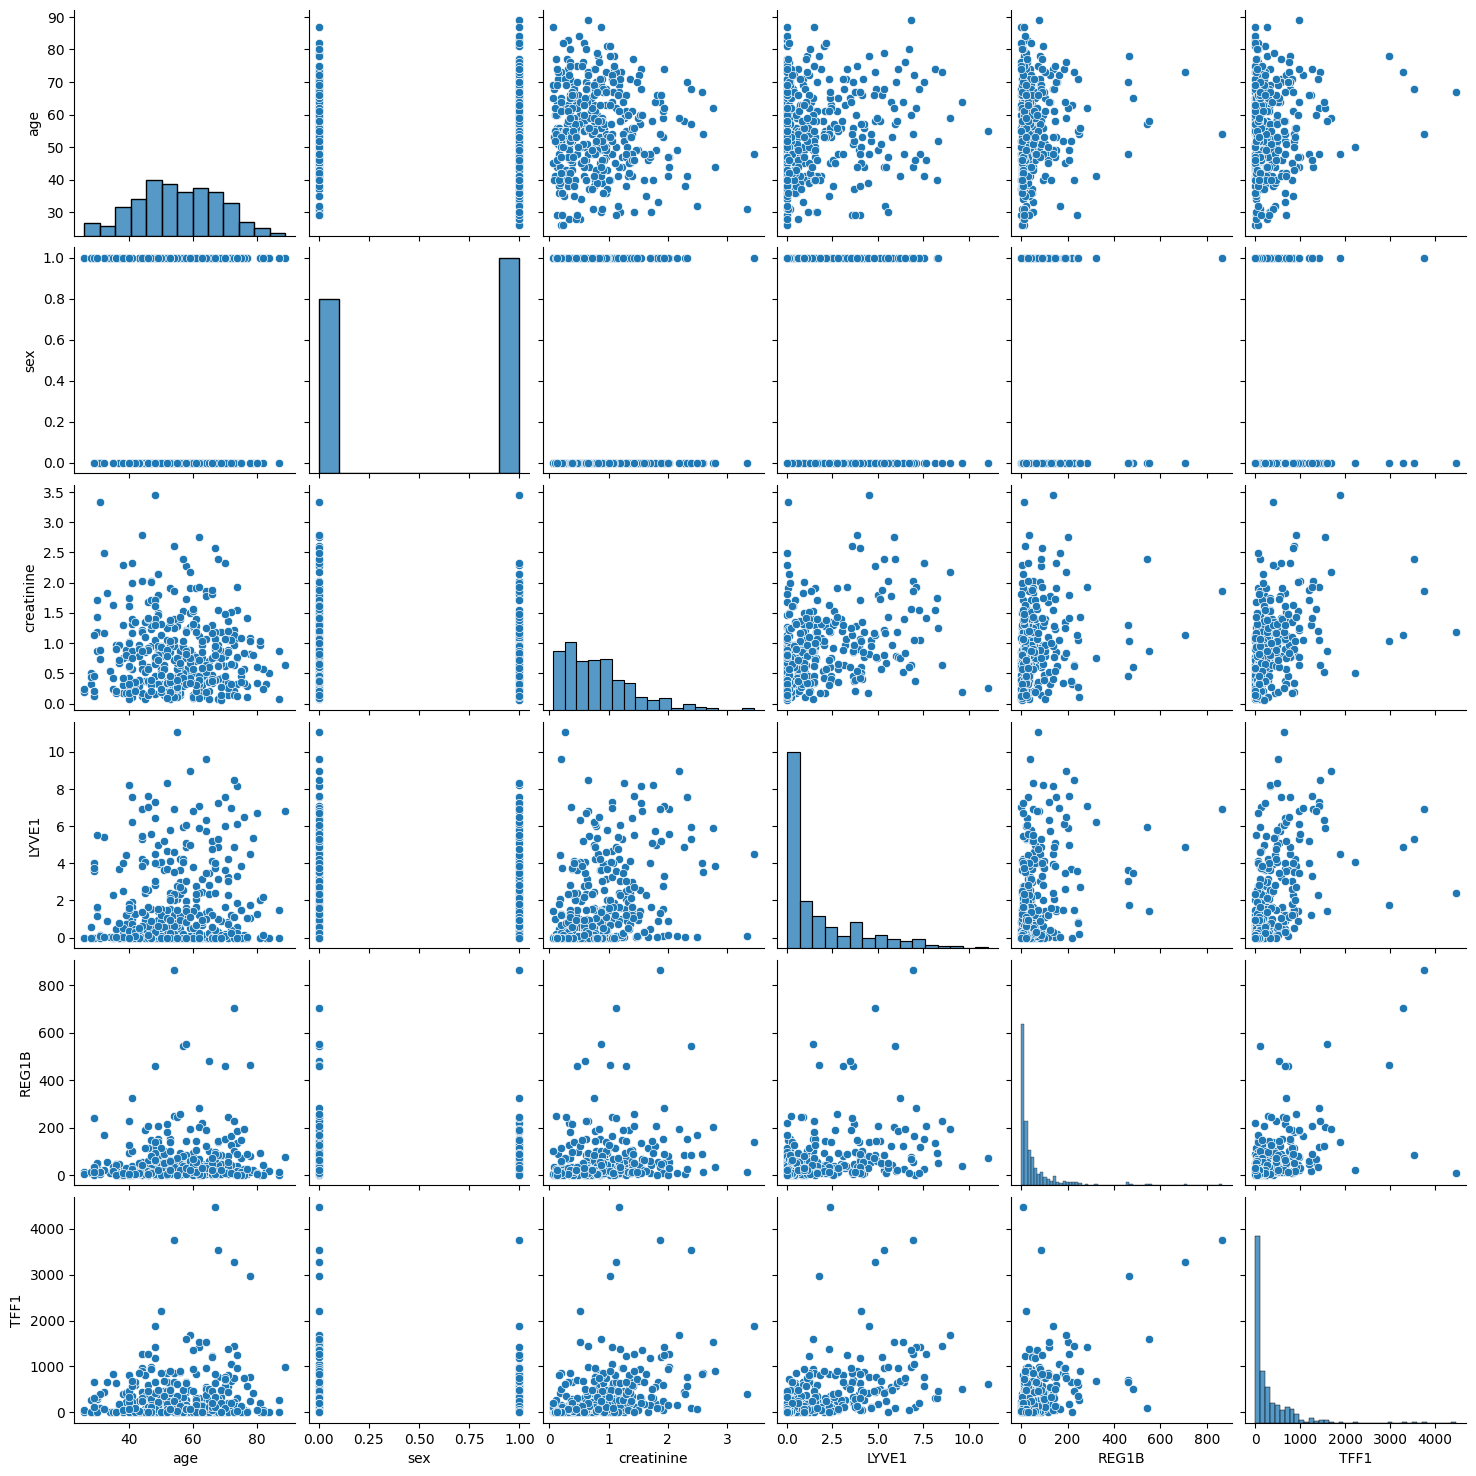

In [363]:
sns.pairplot(healthy)

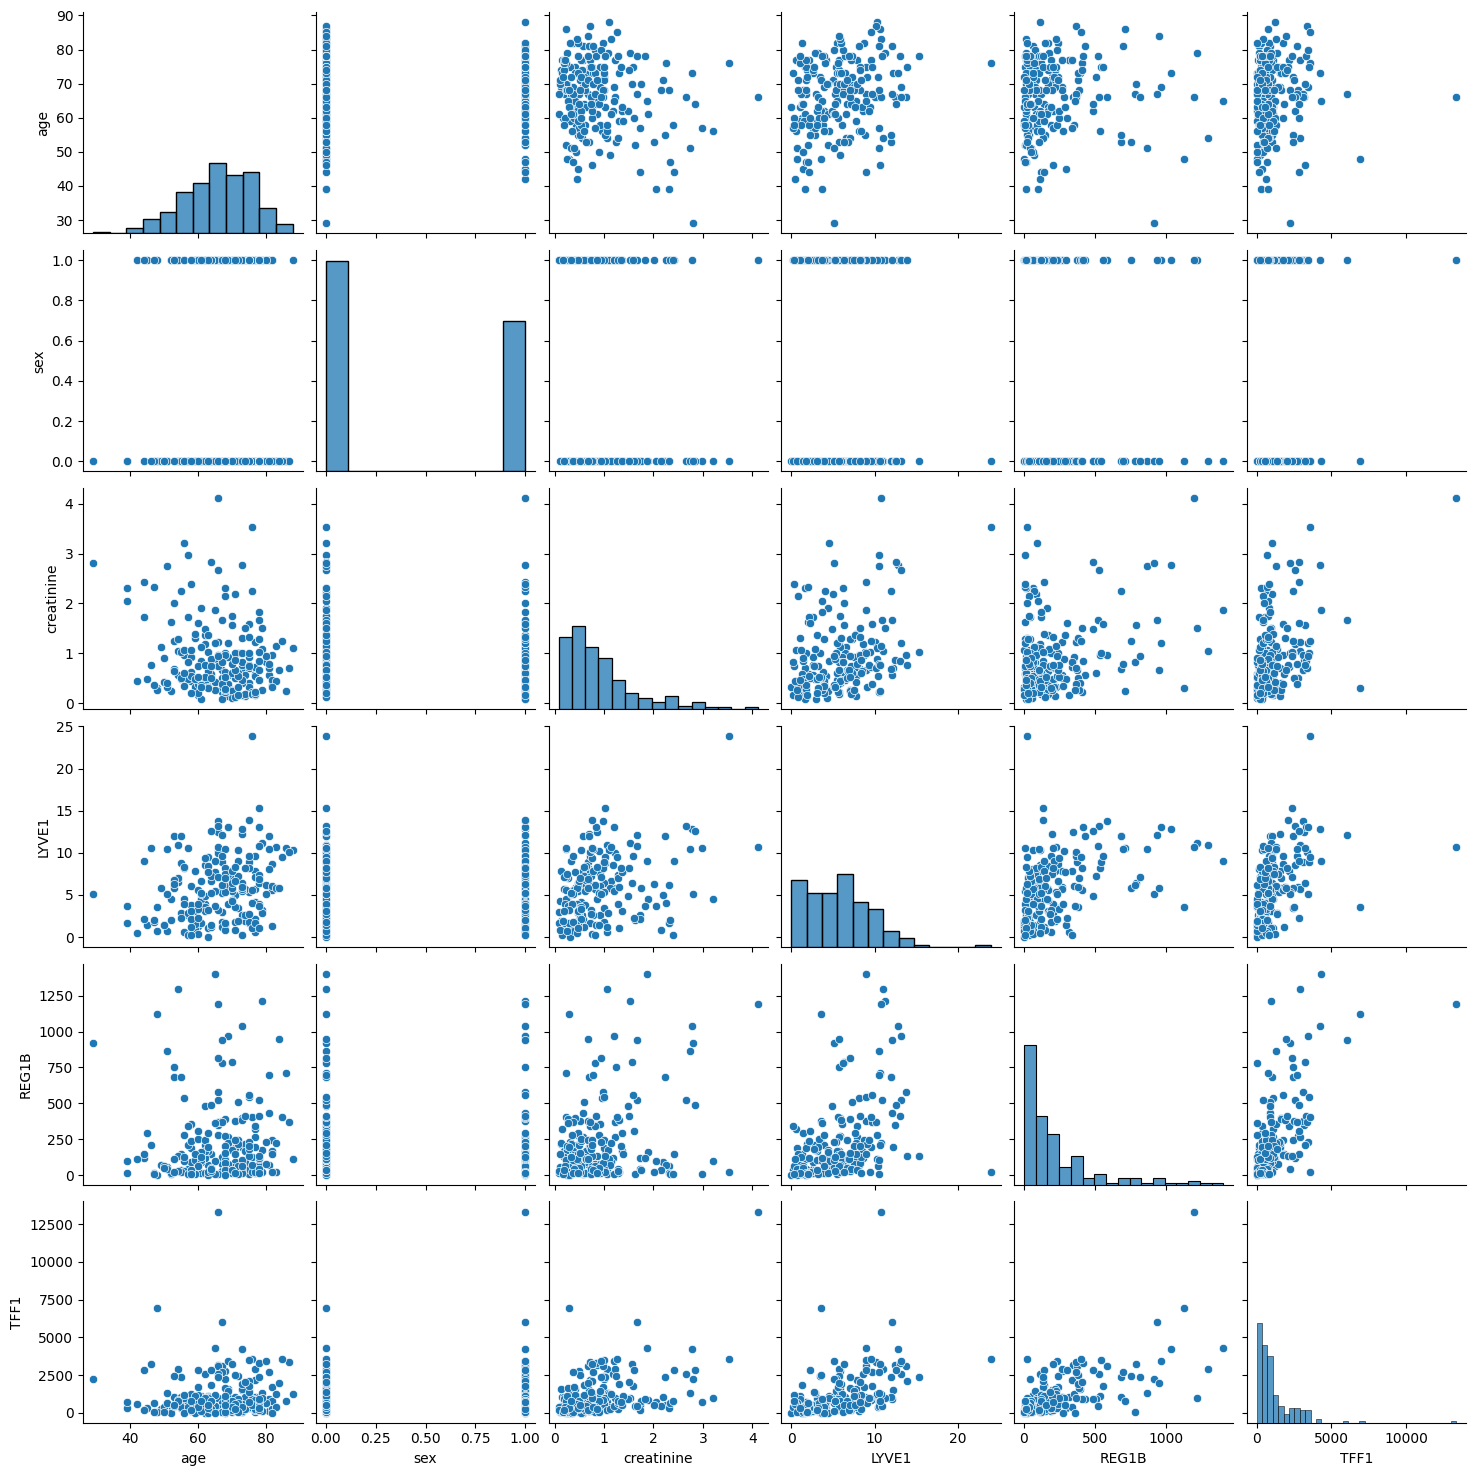

In [364]:
sns.pairplot(cancer)

## Modelo de regresión polinomial

A modo de comparación, evaluaremos la relación entre REG1B y TFF1 tanto para pacientes sanos como con adenocarcinoma.

In [381]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

In [382]:
# Para pacientes sanos
X_s = np.array(healthy['REG1B']).reshape(-1,1)
y_s = np.array(healthy['TFF1']).reshape(-1,1)

# Definimos el grado del polinomio
degree = 8

# Definimos el modelo de regresión no lineal
polyreg_scaled = make_pipeline(PolynomialFeatures(degree), StandardScaler(), LinearRegression())
polyreg_scaled.fit(X_s, y_s)

# Obtenemos los valores predecidos por el modelo
y_pred_s = polyreg_scaled.predict(X_s)

# Métricas de evaluación
r2_s = r2_score(y_s, y_pred_s)

In [383]:
# Utilizamos la misma lógica para pacientes con cáncer
X_c = np.array(cancer['REG1B']).reshape(-1,1)
y_c = np.array(cancer['TFF1']).reshape(-1,1)

# Definimos el grado del polinomio
degree = 8

# Definimos el modelo de regresión no lineal
polyreg_scaled = make_pipeline(PolynomialFeatures(degree), StandardScaler(), LinearRegression())
polyreg_scaled.fit(X_c, y_c)

# Obtenemos los valores predecidos por el modelo
y_pred_c = polyreg_scaled.predict(X_c)

# Métricas de evaluación
r2_c = r2_score(y_c, y_pred_c)

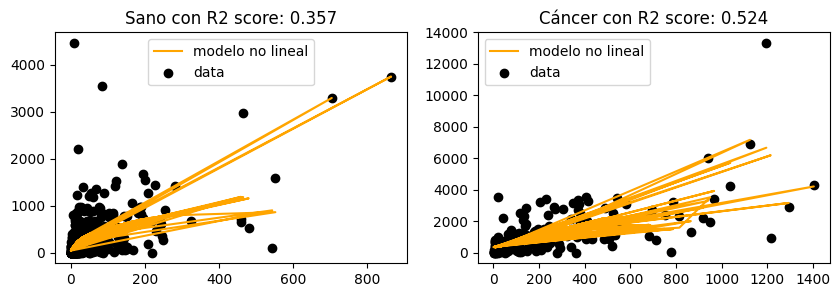

In [384]:
# Visualizando
f, (ax1, ax2) = plt.subplots(1,2, figsize = (10,3))
ax1.plot(X_s, y_pred_s, color = 'orange', label = 'modelo no lineal')
ax1.scatter(X_s, y_s, color = 'black', label = 'data')
ax1.legend()
ax1.set_title(f'Sano con R2 score: {r2_s:.3f}')

ax2.plot(X_c, y_pred_c, color = 'orange', label = 'modelo no lineal')
ax2.scatter(X_c, y_c, color = 'black', label = 'data')
ax2.legend()
ax2.set_title(f'Cáncer con R2 score: {r2_c:.3f}')

plt.show()

Si bien la métrica R2 score es mayor al utilizar un modelo de regresión polinomial con respecto a un modelo lineal (como también lo sugerían los coeficientes de Pearson y Spearman), podemos observar como el primero no generaliza la tendencia de los datos de los biomarcadores TFF1 y REG1B, sino que se ajusta a los datos de entrenamiento (un caso de overfitting).

## Limitaciones

Se reconoce que los siguientes análisis pueden aún ser realizados:
* En el subgrupo de pacientes con adenocarcinoma, evaluar si existe una correlación en los biomarcadores y el estadío del cáncer
* Evaluar si existe diferencia entre los datos provenientes de diferentes cohortes
* En el subgrupo de pacientes con adenocarcinoma testeados para la proteína Cas19-9, evaluar si existe una correlación entre dicha proteína y el diagnóstico
* En el subgrupo de pacientes con adenocarcinoma testeados para la proteína REG1A y REG1B, evaluar cuál de las dos tiene una correlación más positiva con el diagnóstico